In [ ]:
#Reference:
#https://github.com/Molecular-Exploration/toxicity-classification/blob/main/Colab_Notebooks/SMILES_ensemble.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install rdkit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.2 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import chi2
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from rdkit import Chem,DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, Lipinski, Draw
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AML Group/clean_data3.csv')
data.head()

,Unnamed: 0,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class,bioactivity_class_encoded
0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,active,0
1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,inactive,1
2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,active,0
3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,inactive,1
4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,5.1731,2.0,3.0,2.0,3.0,inactive,1


In [ ]:
#FINGERPRINTS

def generate_fingerprint(smiles):

    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    return fingerprint

In [ ]:
fingerprint = data["smiles"].apply(generate_fingerprint)
fingerprint

0       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
                              ...                        
5899    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
5900    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5901    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5902    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5903    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: smiles, Length: 5904, dtype: object

In [ ]:
#convert the fingerprint to a numpy array
def rdkit_numpy_convert(fp):
    output=[]
    for f in fp:
        arr=np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f,arr)
        output.append(arr)
    return np.asarray(output)
        


In [ ]:
X=rdkit_numpy_convert(fingerprint)    
X.shape
#ALL molecules have 2048 molecule fingerprint

(5904, 2048)

In [ ]:
y = data.iloc[:,13]

In [ ]:
#RNN
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Define the RNN model
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=10, batch_size=64, validation_split=0.2)




Epoch 1/10
74/74 [==============================] - 260s 3s/step - loss: 0.6262 - accuracy: 0.6943 - val_loss: 0.5117 - val_accuracy: 0.8103
Epoch 2/10
74/74 [==============================] - 273s 4s/step - loss: 0.6157 - accuracy: 0.6949 - val_loss: 0.5286 - val_accuracy: 0.8103
Epoch 3/10
74/74 [==============================] - 272s 4s/step - loss: 0.6160 - accuracy: 0.6949 - val_loss: 0.5251 - val_accuracy: 0.8103
Epoch 4/10
74/74 [==============================] - 277s 4s/step - loss: 0.6176 - accuracy: 0.6949 - val_loss: 0.5406 - val_accuracy: 0.8103
Epoch 5/10
74/74 [==============================] - 273s 4s/step - loss: 0.6140 - accuracy: 0.6949 - val_loss: 0.5426 - val_accuracy: 0.8103
Epoch 6/10
74/74 [==============================] - 273s 4s/step - loss: 0.6135 - accuracy: 0.6949 - val_loss: 0.5216 - val_accuracy: 0.8103
Epoch 7/10
74/74 [==============================] - 272s 4s/step - loss: 0.6121 - accuracy: 0.6949 - val_loss: 0.5266 - val_accuracy: 0.8103
Epoch 8/10
74

In [ ]:
y_pred = model.predict(X)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y, y_pred_binary))


185/185 [==============================] - 173s 928ms/step
              precision    recall  f1-score   support

           0       0.71      0.03      0.06      1665
           1       0.72      0.99      0.84      4239

    accuracy                           0.72      5904
   macro avg       0.72      0.51      0.45      5904
weighted avg       0.72      0.72      0.62      5904



In [ ]:
print(confusion_matrix(y, y_pred_binary))

[[  54 1611]
 [  22 4217]]


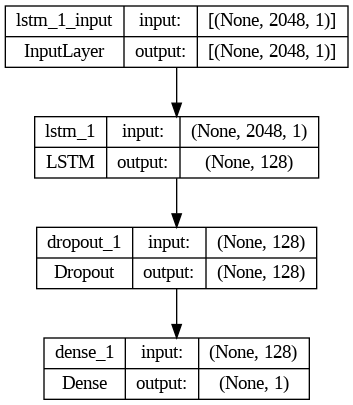

In [ ]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)
Image('model.png')

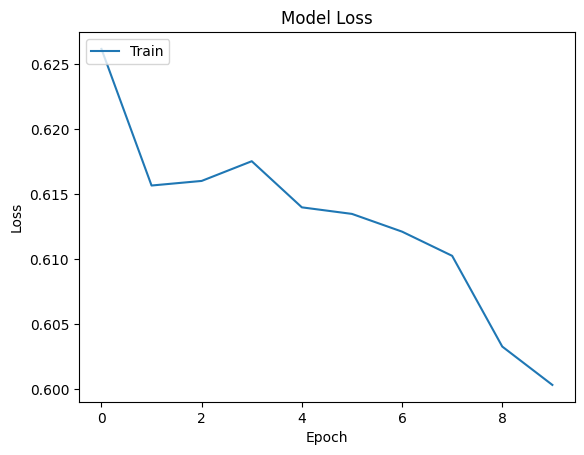

In [ ]:
# Plot the loss function
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()